# Example usage of trainer class

In [1]:
# autoreload after code has changed
%load_ext autoreload
%autoreload 2

In [2]:
import os

# move into the correct dirrectory, e.g. move up one directory level iif this cell is run for the first time
try:
    a = first_time
except NameError:
    print("Running first time, moving up one dir level")
    os.chdir('..')  # Move up one directory level to the root directory of project
    first_time = False

print("This path should be the root directory of the project: ", os.getcwd())
    


Running first time, moving up one dir level
This path should be the root directory of the project:  /home/daniel/Documents/TUM/ADLR/tum-adlr-02


## Define Dataset
Creating the dataset object and applzing transformations to the data.

In [3]:
from data.model_classes import Mug, Bottle
from data.dataconverter import DataConverter

# generate data
dataconverter = DataConverter(
    classes=[Mug(),Bottle()],
    min_order = 1,
    tact_order = 10,
    tact_number=2, 
    rand_rotations=2
    
)
# set regenerate to true, if you run this after changes in dataconverter have been made
#dataconverter.generate_2d_dataset(show_results=False, regenerate=False)


In [4]:
from data.reconstruction_dataset import *

csv_file = './datasets/2D_shapes/annotations.csv'
root_dir = './datasets/2D_shapes'
composed = transforms.Compose([RandomOrientation(),
                               ToTensor()])

dataset = ReconstructionDataset(csv_file=csv_file,
                                root_dir=root_dir,
                                transform=composed)

Examplary data pairs:

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


<Figure size 640x480 with 0 Axes>

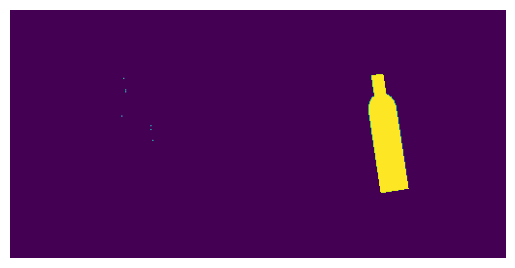

In [5]:
example_data = dataset[5]

plt.figure()
print(example_data['image'])
show_datapair(example_data['image'], example_data['label'])
plt.show()

## Choose Hyperparamters

Look into the file neural_nets.trainer to see which hyperparameters you can choose.
The seperation into tunable and non tunable hyperparameters is made, because this makes parameter searches with ray easier.


#### Non Tunable Hyperparameters


In [6]:
from neural_nets.trainer import NonTHparams


nt_h = NonTHparams()
nt_h.num_epochs = 50
nt_h.train_prop = 0.9 # set way to high to make validation period short and make testing this search easier

nt_h.print_log = True # to better see param search results
nt_h.log_train_period = 100
nt_h.log_val_freq = 5 #int(nt_h.train_prop*len(dataset)/f)-1 #set low to test this parameter search


#### Define Tunable Hyperparameters and parameter spaces for upgrade

The hyperparameters we want to tone have to be put into a list of possible values and that list into a dict, for the hyperparameter optimizer to do its job.

In [7]:
import numpy as np
import torch.nn as nn
import torch.optim as optim

from neural_nets.trainer import THparams
from neural_nets.weight_inits import weight_init_kx
from neural_nets.models.unet import UNet2


from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle

t_h = THparams()
t_h.batch_size = 16

t_h.model = UNet2
t_h.weight_init = weight_init_kx
t_h.depth = 5
t_h.channels = 64

t_h.lr = 1e-4
t_h.optimizer = optim.Adam
t_h.loss_func = nn.BCELoss()


image_resolution = dataset[0]['image'].shape[1]
max_unet_depth = int(np.log2(image_resolution))

# config is the set of params, that will be searched, they got to ghave the same key names, as variables in THparams
config = {
    "batch_size": tune.choice([2 ** i for i in range(2,5)]),
    "lr": tune.loguniform(1e-9, 1e-2),
    "depth": tune.choice([i for i in range(3,max_unet_depth+1-2)]),
    "channels": tune.choice([2 ** i for i in range(4,9)])
}




## Initialize Trainer

In [8]:
from neural_nets.trainer import Trainer

trainer = Trainer(nt_h, t_h, dataset)



During training, progress will be logged to tensorboard. Go to project folder, activate appropritae conda environment and run 'tensorboard --logdir runs/' to see the logs.


## Run Parameter Search

In [ ]:
import ray
import GPUtil

num_samples=40
max_num_epochs=4*nt_h.log_val_freq # it is not num epochs, but how often we calculae val loss (we can also calc it mid epoch) todo: make it more logical
gpus_per_trial = 1

os.environ["RAY_CHDIR_TO_TRIAL_DIR"] = "0" # needed so that we still can load files using path relative to working directory, 
                                           # as these fuckers change it 
ray.shutdown()
context = ray.init(num_cpus=10)
print("Ray dashboard URL: ", context.dashboard_url)


scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2,
    )

def tune_func(config):
    tune.utils.wait_for_gpu(target_util=0.2)
    trainer.train_from_dict(config)

result = tune.run(
        tune_func,
        resources_per_trial={"cpu": 10, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,

        raise_on_failed_trial=False,
    )

best_trial = result.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")


2024-06-23 02:30:35,600	INFO worker.py:1761 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2024-06-23 02:30:36,363	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Ray dashboard URL:  127.0.0.1:8265


(tune_func pid=59746) Hurray! GPU available.
(tune_func pid=59746) Total trainable parameters: 442497
(tune_func pid=59746) Epoch [1/50], Step [100/5769], Train Loss: 0.2453 , Logging Time Proportion: 0.0034, Data Loading Time Proportion: 0.0053
(tune_func pid=59746) Epoch [1/50], Step [200/5769], Train Loss: 0.2301 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0057
(tune_func pid=59746) Epoch [1/50], Step [300/5769], Train Loss: 0.2255 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0054
(tune_func pid=59746) Epoch [1/50], Step [400/5769], Train Loss: 0.2266 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0058
(tune_func pid=59746) Epoch [1/50], Step [500/5769], Train Loss: 0.2254 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0056
(tune_func pid=59746) Epoch [1/50], Step [600/5769], Train Loss: 0.2231 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0051
(tune_func pid=59746) Epoch [1/50]

Trial name,loss,should_checkpoint
tune_func_cf41b_00000,0.226118,True


(tune_func pid=59746) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_02-30-36/tune_func_cf41b_00000_0_batch_size=4,channels=32,depth=3,lr=0.0064_2024-06-23_02-30-37/checkpoint_000000)


(tune_func pid=59746) #######################################################################################
(tune_func pid=59746) Epoch [1/50], Step [1153/5769], Val Loss: 0.2253 Val Log Time Proportion: 0.3692
(tune_func pid=59746) #######################################################################################
(tune_func pid=59746) Epoch [1/50], Step [1200/5769], Train Loss: 0.2275 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0010
(tune_func pid=59746) Epoch [1/50], Step [1300/5769], Train Loss: 0.2259 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0055
(tune_func pid=59746) Epoch [1/50], Step [1400/5769], Train Loss: 0.2250 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0058
(tune_func pid=59746) Epoch [1/50], Step [1500/5769], Train Loss: 0.2278 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0058
(tune_func pid=59746) Epoch [1/50], Step [1600/5769], Train Loss: 0.2254 , Logging Time Proportio

(tune_func pid=59746) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_02-30-36/tune_func_cf41b_00000_0_batch_size=4,channels=32,depth=3,lr=0.0064_2024-06-23_02-30-37/checkpoint_000001)


(tune_func pid=59746) #######################################################################################
(tune_func pid=59746) Epoch [1/50], Step [2306/5769], Val Loss: 0.2261 Val Log Time Proportion: 0.1038
(tune_func pid=59746) #######################################################################################
(tune_func pid=59746) Epoch [1/50], Step [2400/5769], Train Loss: 0.2272 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0026
(tune_func pid=59746) Epoch [1/50], Step [2500/5769], Train Loss: 0.2258 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0054
(tune_func pid=59746) Epoch [1/50], Step [2600/5769], Train Loss: 0.2234 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0054
(tune_func pid=59746) Epoch [1/50], Step [2700/5769], Train Loss: 0.2251 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0055
(tune_func pid=59746) Epoch [1/50], Step [2800/5769], Train Loss: 0.2278 , Logging Time Proportio

(tune_func pid=59746) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_02-30-36/tune_func_cf41b_00000_0_batch_size=4,channels=32,depth=3,lr=0.0064_2024-06-23_02-30-37/checkpoint_000002)


(tune_func pid=59746) Epoch [1/50], Step [3500/5769], Train Loss: 0.2274 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0011
(tune_func pid=59746) Epoch [1/50], Step [3600/5769], Train Loss: 0.2244 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0045
(tune_func pid=59746) Epoch [1/50], Step [3700/5769], Train Loss: 0.2271 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0043
(tune_func pid=59746) Epoch [1/50], Step [3800/5769], Train Loss: 0.2258 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0047
(tune_func pid=59746) Epoch [1/50], Step [3900/5769], Train Loss: 0.2291 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0042
(tune_func pid=59746) Epoch [1/50], Step [4000/5769], Train Loss: 0.2257 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0049
(tune_func pid=59746) Epoch [1/50], Step [4100/5769], Train Loss: 0.2289 , Logging Time Proportion: 0.0012, Data Loading Time Prop

(tune_func pid=59746) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_02-30-36/tune_func_cf41b_00000_0_batch_size=4,channels=32,depth=3,lr=0.0064_2024-06-23_02-30-37/checkpoint_000003)


(tune_func pid=59746) #######################################################################################
(tune_func pid=59746) Epoch [1/50], Step [4612/5769], Val Loss: 0.2262 Val Log Time Proportion: 0.1190
(tune_func pid=59746) #######################################################################################
(tune_func pid=59746) Epoch [1/50], Step [4700/5769], Train Loss: 0.2256 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0020
(tune_func pid=59746) Epoch [1/50], Step [4800/5769], Train Loss: 0.2280 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0053
(tune_func pid=59746) Epoch [1/50], Step [4900/5769], Train Loss: 0.2270 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0050
(tune_func pid=59746) Epoch [1/50], Step [5000/5769], Train Loss: 0.2290 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0045
(tune_func pid=59746) Epoch [1/50], Step [5100/5769], Train Loss: 0.2272 , Logging Time Proportio

(tune_func pid=59746) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_02-30-36/tune_func_cf41b_00000_0_batch_size=4,channels=32,depth=3,lr=0.0064_2024-06-23_02-30-37/checkpoint_000004)


(tune_func pid=59746) #######################################################################################
(tune_func pid=59746) Epoch [1/50], Step [5765/5769], Val Loss: 0.2262 Val Log Time Proportion: 0.1004
(tune_func pid=59746) #######################################################################################
(tune_func pid=59746) Epoch [2/50], Step [31/5769], Train Loss: 0.0710 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0023
(tune_func pid=59746) Epoch [2/50], Step [131/5769], Train Loss: 0.2267 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0078
(tune_func pid=59746) Epoch [2/50], Step [231/5769], Train Loss: 0.2258 , Logging Time Proportion: 0.0029, Data Loading Time Proportion: 0.0079
(tune_func pid=59746) Epoch [2/50], Step [331/5769], Train Loss: 0.2261
(tune_func pid=59746)  , Logging Time Proportion: 0.0028, Data Loading Time Proportion: 0.0080
(tune_func pid=59746) Epoch [2/50], Step [431/5769], Train Loss: 0.2277 , Loggi

(tune_func pid=59746) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_02-30-36/tune_func_cf41b_00000_0_batch_size=4,channels=32,depth=3,lr=0.0064_2024-06-23_02-30-37/checkpoint_000005)


(tune_func pid=59746) Epoch [2/50], Step [1231/5769], Train Loss: 0.2257 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0027
(tune_func pid=59746) Epoch [2/50], Step [1331/5769], Train Loss: 0.2230 , Logging Time Proportion: 0.0028, Data Loading Time Proportion: 0.0074
(tune_func pid=59746) Epoch [2/50], Step [1431/5769], Train Loss: 0.2270 , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0086
(tune_func pid=59746) Epoch [2/50], Step [1531/5769], Train Loss: 0.2246 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0078
(tune_func pid=59746) Epoch [2/50], Step [1631/5769], Train Loss: 0.2253 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0077
(tune_func pid=59746) Epoch [2/50], Step [1731/5769], Train Loss: 0.2277 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0074
(tune_func pid=59746) Epoch [2/50], Step [1831/5769], Train Loss: 0.2275 , Logging Time Proportion: 0.0022, Data Loading Time Prop

(tune_func pid=59746) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_02-30-36/tune_func_cf41b_00000_0_batch_size=4,channels=32,depth=3,lr=0.0064_2024-06-23_02-30-37/checkpoint_000006)


(tune_func pid=59746) #######################################################################################
(tune_func pid=59746) Epoch [2/50], Step [2306/5769], Val Loss: 0.2260 Val Log Time Proportion: 0.4225
(tune_func pid=59746) #######################################################################################
(tune_func pid=59746) Epoch [2/50], Step [2331/5769], Train Loss: 0.2269 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0012
(tune_func pid=59746) Epoch [2/50], Step [2431/5769], Train Loss: 0.2253 , Logging Time Proportion: 0.0029, Data Loading Time Proportion: 0.0078
(tune_func pid=59746) Epoch [2/50], Step [2531/5769], Train Loss: 0.2249 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0073
(tune_func pid=59746) Epoch [2/50], Step [2631/5769], Train Loss: 0.2270 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0075
(tune_func pid=59746) Epoch [2/50], Step [2731/5769], Train Loss: 0.2269 , Logging Time Proportio

(tune_func pid=59746) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_02-30-36/tune_func_cf41b_00000_0_batch_size=4,channels=32,depth=3,lr=0.0064_2024-06-23_02-30-37/checkpoint_000007)


(tune_func pid=59746) Epoch [2/50], Step [3531/5769], Train Loss: 0.2277 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0019
(tune_func pid=59746) Epoch [2/50], Step [3631/5769], Train Loss: 0.2272 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0065
(tune_func pid=59746) Epoch [2/50], Step [3731/5769], Train Loss: 0.2261 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0063
(tune_func pid=59746) Epoch [2/50], Step [3831/5769], Train Loss: 0.2259 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0064
(tune_func pid=59746) Epoch [2/50], Step [3931/5769], Train Loss: 0.2243 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0065
(tune_func pid=59746) Epoch [2/50], Step [4031/5769], Train Loss: 0.2238 , Logging Time Proportion: 0.0018, Data Loading Time Proportion: 0.0067
(tune_func pid=59746) Epoch [2/50], Step [4131/5769], Train Loss: 0.2262 , Logging Time Proportion: 0.0016, Data Loading Time Prop

In [ ]:
print(result)